In [93]:
import torch
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import umap.umap_ as umap
import pickle
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
from utils.args import args

In [94]:
'''
    args:
        - features_data: dict of features extracted ("features", list(uid,video_name,features_RGB))
        - dataframe: for each unique frame (udi,partecipant_id,video_id,narration,start_timestamp,stop_timestamp,start_frame,stop_frame,verb,verb_class)
    return:
        - extracted_features: DataFrame with the extracted_features of the modality of interest, the related image path of the middle frame and the label associated with the clip
'''
def get_features_labels(features_data, dataframe, modality="RGB") -> pd.DataFrame:
    
    data = []

    for _, features_list in features_data.items():

        for features in features_list:

            feat_clip = features.get(f"features_{modality}")

            info_clip = dataframe[dataframe["uid"] == features.get("uid")]

            start_frame = info_clip['start_frame'].tolist()
            stop_frame = info_clip['stop_frame'].tolist()
            central_image = (stop_frame[0] - start_frame[0]) // 2 + start_frame[0]

            frames_path = './ek_data/frames/' + features.get("video_name")
            image_path = frames_path + "/" + [frame for frame in os.listdir(frames_path) if str(central_image) in frame][0]
            
            data.append({
                "features": feat_clip,
                "image": image_path,
                "uid": info_clip["uid"].values[0],
                "verb_class": info_clip["verb_class"].values[0]
            })

    return pd.DataFrame(data)

def plot_features_labels_clusters(path, dataframe, title=""):
    with open(path, 'rb') as file:
        features_data = pickle.load(file)

    data = get_features_labels(features_data, dataframe)

    features = data["features"]
    # features is a list of 435 elements (one for clip) of 5*1024 features rgb * clip (5 vectors of 1024 elements)
    aggregated_features = []
    for f in features:
        aggregated_features.append(np.mean(f, axis=0))
    # aggregated_features is a list of 435 elements (one for clip) of 1024 features rgb * clip

    num_clusters = 8

    # Initialize K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(aggregated_features)
    data['cluster'] = cluster_labels

    # Apply TSNE for dimensionality reduction
    # reduced = TSNE(n_components=2, learning_rate="auto", random_state=0, verbose=0, init="pca").fit_transform(np.array(aggregated_features))
    reducer = umap.UMAP(n_components=2, random_state=42, verbose=0)
    reduced = reducer.fit_transform(np.array(aggregated_features))
    data['x'] = reduced[:, 0]
    data['y'] = reduced[:, 1]

    # Define labels and colors
    LABELS = {
        0: "take (get)",
        1: "put-down (put/place)",
        2: "open",
        3: "close",
        4: "wash (clean)",
        5: "cut",
        6: "stir (mix)",
        7: "pour"
    }
    COLORS = {i: x for i, x in enumerate(sns.color_palette("tab10", len(LABELS)).as_hex())}

    plt.figure(figsize=(18, 9))
    plt.suptitle(f"UMAP Visualization for {title}")

    plt.subplot(1, 2, 1)
    for i in range(len(LABELS.keys())):
        filtered = data[data['verb_class'] == i]
        plt.scatter(filtered['x'], filtered['y'], c=COLORS[i], label=LABELS[i])
    plt.legend()
    plt.title("UMAP by Verb Class")

    plt.subplot(1, 2, 2)
    for i in range(len(LABELS.keys())):
        filtered = data[data['cluster'] == i]
        plt.scatter(filtered['x'], filtered['y'], c=COLORS[i], label='Cluster - ' + str(i))
    plt.legend()
    plt.title("TSNE by Cluster")

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
    plt.show()
    plt.close()


In [95]:
with open('./train_val/D1_test.pkl', 'rb') as file:
        data = pickle.load(file)
        df = pd.DataFrame(data)

if args.gpus is not None:
        os.environ['CUDA_VISIBLE_DEVICES'] = args.gpus
else:
        os.environ['CUDA_VISIBLE_DEVICES'] = "2"
        os.environ['OMP_NUM_THREADS'] = "2"
        

In [96]:
plot_features_labels_clusters('./saved_features/EK_D1_5_dense_save.pkl', df, "EK 5 frames - Dense sampling" )

c:\Users\Nunzi\anaconda3\envs\aml23-ego\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


TypeError: '<' not supported between instances of 'str' and 'float'

c:\Users\Nunzi\anaconda3\envs\aml23-ego\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Nunzi\anaconda3\envs\aml23-ego\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


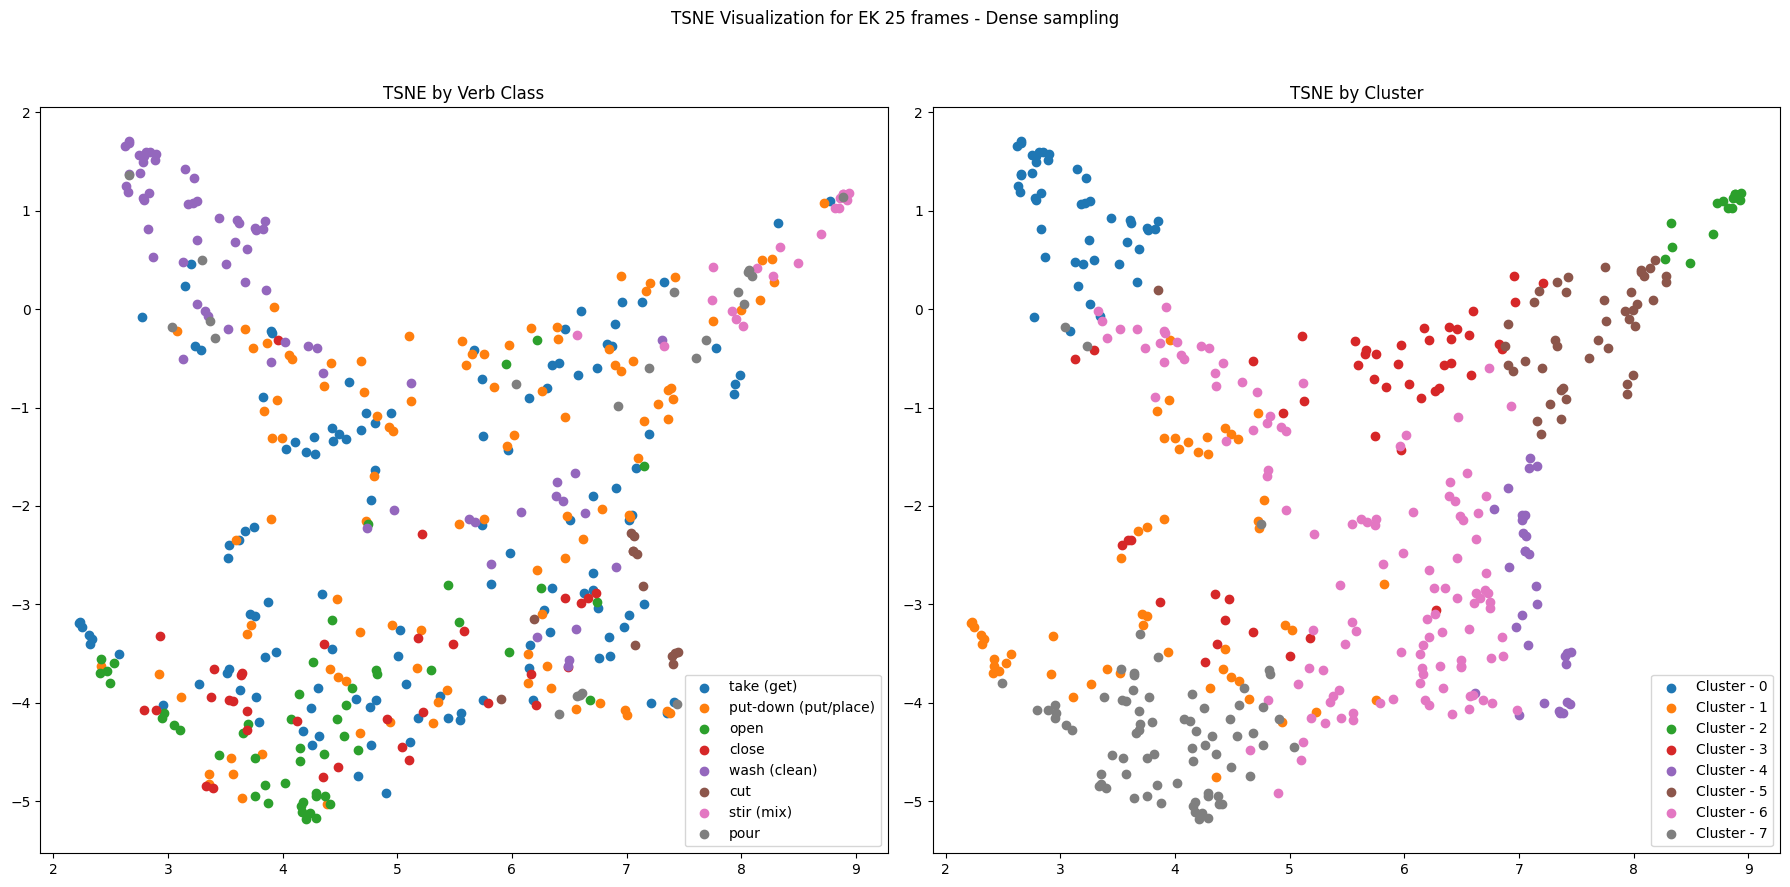

In [ ]:
plot_features_labels_clusters('./saved_features/EK_D1_25_dense_save.pkl', df, "EK 25 frames - Dense sampling" )

c:\Users\Nunzi\anaconda3\envs\aml23-ego\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Nunzi\anaconda3\envs\aml23-ego\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


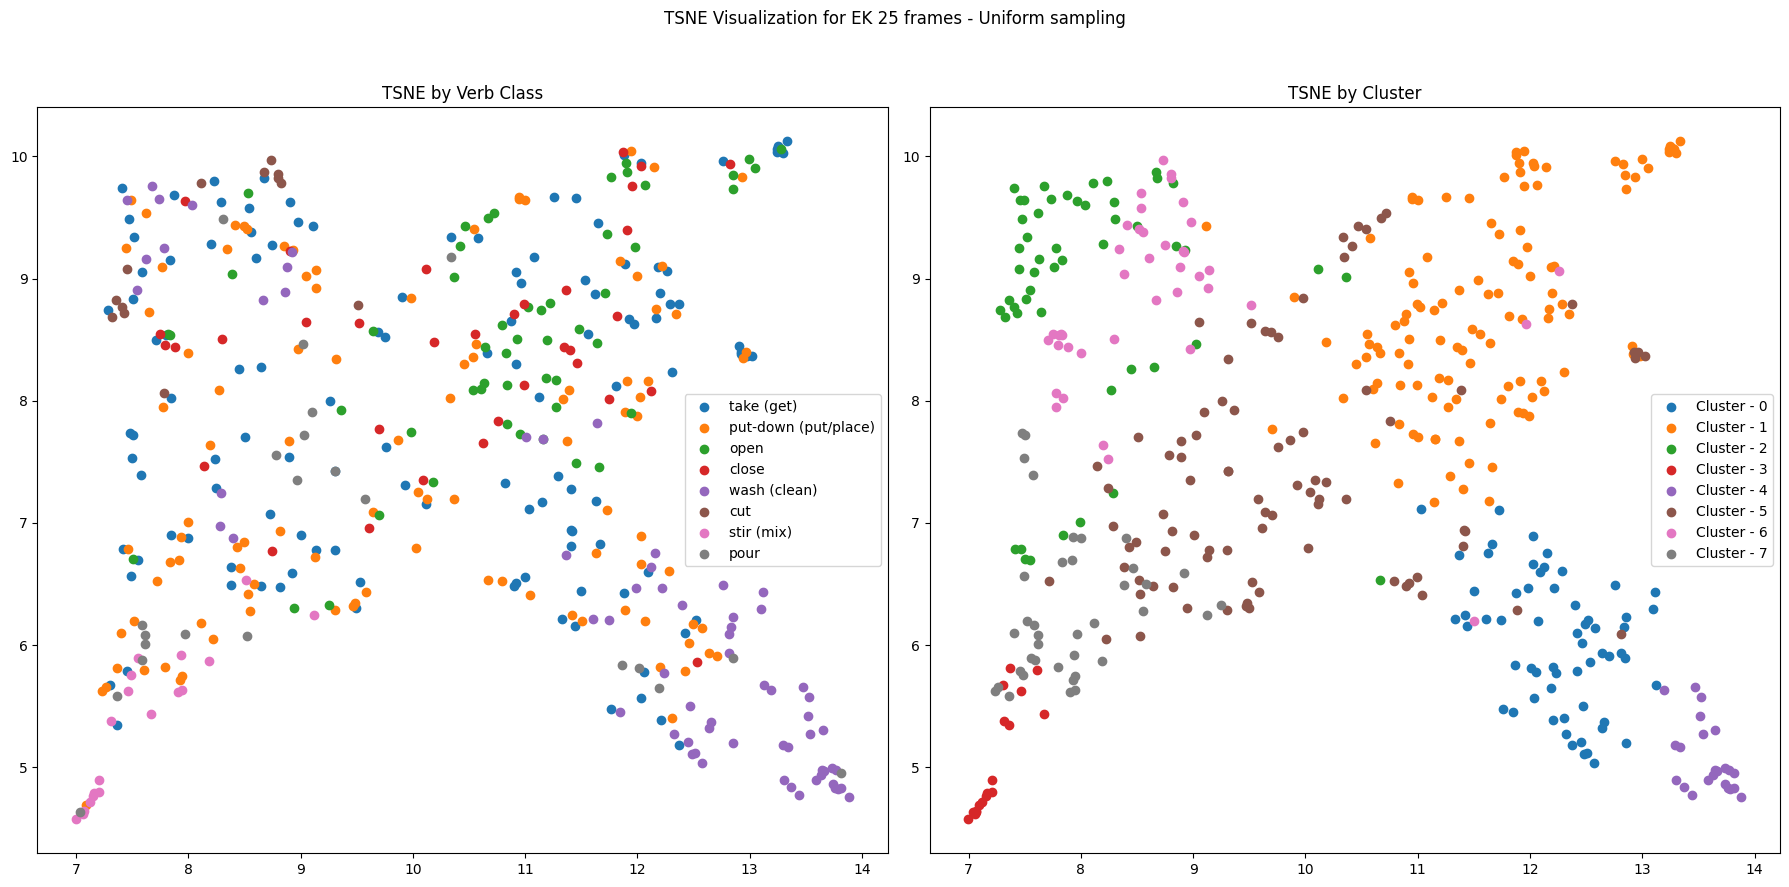

In [ ]:
plot_features_labels_clusters('./saved_features/EK_D1_25_uniform_save.pkl', df, "EK 25 frames - Uniform sampling" )